# JAX Implementation of PINN solution of an inverse problem with the Viscous Burgers PDE

Scientific Machine Learning Workshop at Cenpes 2025<br>
This code is distributed under the GNU LGPL license.<br>
Last Modified: Aug 2025<br>

Simple JAX implementation of PINN solution<br>
of an inverse problem with the Viscouse Burgers PDE<br>
with sinusoidal IC, where the viscosity is estimated from sample data<br>
Uses elements of the code in [1].

Author: Ulisses Braga-Neto<br>
Department of Electrical and Computer Engineering<br>
Texas A&M University

This python code demonstrates training a physics-informed neural networks (PINN) to find the viscosity from scattered noisy data generated by a Burgers nonlinear PDE with a sinusoidal initial condition and homogeneous Dirichlet boundary conditions:

  \begin{aligned}
  &u_t + uu_x = \nu u_{xx}\,, \quad (x,t) \in [-1,1] \times [0,\infty)\,,\\
    & u(x,0) = -\sin(\pi x)\,, \quad -1 < x < 1\,, \\
    &u(1,t) = u(-1,t) = 0\,, \quad t>0\,,\quad\quad\quad\quad\quad\quad  (1)\\
  \end{aligned}

where $\nu>0$ is the unknown kinematic viscosity.

The data to train the PINN is generated by sampling an accurate Gauss-Hermite quadrature of the Cole-Hopf formula for the exact solution. The quadrature approximation is based on the fact that, for small enough $\nu$, (1) becomes an approximation of the inviscid Burgers problem, in which case it can be proved using the method of characteristics that any zero value in the initial condition stays constant at zero throughout the solution.
Therefore, (1) is approximately equal to the initial-value problem (IVP):
\begin{aligned}
  &\hat{u}_t + \hat{u}\hat{u}_x = \nu \hat{u}_{xx}\,, \quad (x,t) \in R \times [0,\infty)\,,\\
    & \hat{u}(x,0) = \begin{cases} -\sin(\pi x)\,,& -1 < x < 1\,,\\
    0\,, & |x|>1\,. \end{cases} \quad\quad\quad\quad  (2)\\
  \end{aligned}
The Cole-Hopf transform [2] provides a closed-form solution to the IVP (2):

$$\hat{u}(x,t) = -\frac{\int_{-\infty}^\infty \sin(\pi(x-z))\exp\left(-\frac{\cos(\pi(x-z))}{2\pi \nu}\right)\exp\left(-\frac{z^2}{4\nu t}\right)\, dz}
{\int_{-\infty}^\infty \exp\left(-\frac{\cos(\pi(x-z))}{2\pi \nu}\right)\exp\left(-\frac{z^2}{4\nu t}\right)\, dz}\,.$$

For sufficiently small $t$, we have $u(x,t) \approx \hat{u}(x,t)$, for $x \in [-1,1]$. In [3], it is claimed that Gauss-Hermite quadrature produced a seven-digit accurate result for $u_x(0,t)$ up to $t = 3/\pi$ with a viscosity $\nu = 0.01/\pi$.

References:

[1] https://github.com/ASEM000/Physics-informed-neural-network-in-JAX

[2]  E. Hopf, The partial differential equation $u_t + uu_x = \mu u_{xx}$. Comm. Pure Appl. Math. 3, 201-230, 1950.

[3] Claude Basdevant, Michel Deville, Pierre Haldenwang, J Lacroix,
  J Ouazzani, Roger Peyret, Paolo Orlandi, Anthony Patera,
  Spectral and finite difference solutions of the Burgers equation,
  Computers and Fluids,   Volume 14, Number 1, 1986, pages 23-41.

In [1]:
"""
Import libraries
"""

import jax
import jax.numpy as jnp
import numpy as np
import scipy.io
import math
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import optax
from scipy.stats.qmc import LatinHypercube as lhs

In [3]:
"""
Problem Definition and Quadrature Solution
"""

from numpy.polynomial.hermite import hermgauss

nu = 0.01/np.pi # viscosity parameter
sigma = 0.2 # noise standard deviation

# define grid for quadrature solution
# this will also be the test grid for the PINN
utn = 100
uxn = 256
xlo = -1.0
xhi = +1.0
ux = np.linspace(xlo,xhi,uxn)
tlo = 0.0
thi = 1.0
ut = np.linspace(tlo,thi,utn)

qn = 64 # order of quadrature rule
qx,qw = hermgauss(qn)

# compute solution u(x,t) by quadrature of analytical formula:
u_quad = np.zeros([uxn,utn],dtype=np.float32)
for utj in range(utn):
  if (ut[utj]==0.0):
    for uxj in range(uxn):
      u_quad[uxj,utj] = -np.sin(np.pi*ux[uxj])
  else:
    for uxj in range(uxn):
      top = 0.0
      bot = 0.0
      for qj in range(qn):
        c = 2.0*np.sqrt(nu*ut[utj])
        top = top-qw[qj]*c*np.sin(np.pi*(ux[uxj]-c*qx[qj]))*np.exp(-np.cos(np.pi*(ux[uxj]-c*qx[qj]))/(2.0*np.pi*nu))
        bot = bot+qw[qj]*c*np.exp(-np.cos(np.pi*(ux[uxj]-c*qx[qj]))/(2.0*np.pi*nu))
        u_quad[uxj,utj] = top/bot

In [4]:
# solution neural network

def PINN(x,t,params):
  X = jnp.concatenate([x,t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

In [5]:
# weight initialization

def init_params(layer_sizes):
  keys = jax.random.split(jax.random.PRNGKey(0),len(layer_sizes)-1)
  params = list()
  for key,n_in,n_out in zip(keys,layer_sizes[:-1],layer_sizes[1:]):
    lb,ub = -jnp.sqrt(2/(n_in+n_out))/.8796,jnp.sqrt(2/(n_in+n_out))/.8796 # xavier initialization lower and upper bound
    W = jax.random.truncated_normal(key,lower=lb,upper=ub,shape=(n_in,n_out))
    B = np.zeros(n_out)
    params.append({'W':W,'B':B})
  return params

In [6]:
# loss function

@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)

def loss(params,visc,xcl,tcl,xs,ts,us):

    us_pred  = PINN(xs,ts,params)
    ufunc = lambda x,t:PINN(x,t,params)
    r_pred = r_PINN(ufunc,xcl,tcl,visc)

    # loss components
    mse_s  = MSE(us,us_pred)
    mse_r  = MSE(r_pred,0)

    return  mse_s+mse_r

In [7]:
# sensor placement
Nx = 128 # number of uniformly spaced sensor locations
snap = np.array([0,0.125,0.25,0.375,0.5,0.625,0.75,0.875]) # snapshot times
Nt = len(snap)
Ns = Nx*Nt
xs = np.repeat(xlo+(np.arange(Nx)+0.5)*(xhi-xlo)/Nx,Nt).reshape(-1,1)
ts = np.tile(tlo+snap*(thi-tlo),Nx).reshape(-1,1)
idx = np.floor(uxn*(xs-xlo)/(xhi-xlo)).astype(int)
idt = np.floor(utn*(ts-tlo)/(thi-tlo)).astype(int)

In [8]:
# MLP params and viscosity gradients and update

@jax.jit
def grad_update(opt_state,opt_state_visc,params,visc,xcl,tcl,xs,ts,us):

  # compute loss
  loss_value = loss(params,visc,xcl,tcl,xs,ts,us)

  # Get the gradient w.r.t to MLP params and visc
  grads_MLP,grads_visc  = jax.jit(jax.grad(loss,(0,1)))(params,visc,xcl,tcl,xs,ts,us)

  #Update MLP params and visc
  updates_MLP,opt_state = optimizer.update(grads_MLP,opt_state)
  params = optax.apply_updates(params,updates_MLP)
  updates_visc,opt_state_visc = optimizer_visc.update(grads_visc,opt_state_visc)
  visc = optax.apply_updates(visc,updates_visc)
  visc = jnp.clip(visc,min=0.0001)

  return opt_state,opt_state_visc,params,visc,loss_value

In [9]:
# training loop

M = 1 # number of repetitions
N = 10000 # number of training iterations
vhat = np.zeros([M,N]) # store the viscosity estimate
l = np.zeros([M,N]) # store the training loss

rng = np.random.default_rng()

for r in range(M):

  print('\nrepetition: '+str(r+1))

  # sensor data
  us = u_quad[idx,idt]+0*np.random.normal(xs.shape)

  # collocation points
  Ncl = 10000
  X = lhs(2).random(Ncl)
  xcl = xlo+(xhi-xlo)*X[:,0].reshape(-1,1)
  tcl = tlo+(thi-tlo)*X[:,1].reshape(-1,1)

  # initialize new instance of NN
  layer_sizes = [2] + 8*[20] + [1]
  params = init_params(layer_sizes)

  # residual neural network
  def r_PINN(u,x,t,visc):
    u_x  = lambda x,t:jax.grad(lambda x,t:jnp.sum(u(x,t)),0)(x,t)
    u_xx = lambda x,t:jax.grad(lambda x,t:jnp.sum(u_x(x,t)),0)(x,t)
    u_t  = lambda x,t:jax.grad(lambda x,t:jnp.sum(u(x,t)),1)(x,t)
    return u_t(x,t) + u(x,t)*u_x(x,t) - visc*u_xx(x,t)

  # initialize viscosity estimate
  visc = np.power(10,2*rng.random()-3)/np.pi
  print('initial viscosity estimate = {:.4f}/pi'.format(np.pi*visc))

  # Adam optimizer
  lr_MLP = optax.constant_schedule(1e-3)
  optimizer = optax.adam(lr_MLP,b1=0.99)
  lr_visc = optax.constant_schedule(1e-3)
  optimizer_visc = optax.adam(lr_visc,b1=0.99)
  opt_state = optimizer.init(params)
  opt_state_visc = optimizer_visc.init(visc)

  for iter in range(N):

    opt_state,opt_state_visc,params,visc,loss_value = grad_update(opt_state,opt_state_visc,params,visc,xcl,tcl,xs,ts,us)

    if (visc==0.0001):
      print('viscosity too small')

    # record current parameter estimate and loss
    vhat[r,iter] = visc
    l[r,iter] = loss_value

    if ((iter+1)%1000==0):
      print('iteration: '+str(iter+1))
      print('training loss = %.4e' % loss_value)
      print('viscosity estimate = {:.4f}/pi'.format(np.pi*visc))
      print('relative error = {:.2e}'.format(np.abs(visc-nu)/nu))


repetition: 1
initial viscosity estimate = 0.0263/pi
iteration: 1000
training loss = 7.4590e-02
viscosity estimate = 0.0263/pi
relative error = 1.63e+00
iteration: 2000
training loss = 2.4206e-02
viscosity estimate = 0.0196/pi
relative error = 9.60e-01
iteration: 3000
training loss = 1.4416e-02
viscosity estimate = 0.0246/pi
relative error = 1.46e+00
iteration: 4000
training loss = 1.4423e-03
viscosity estimate = 0.0182/pi
relative error = 8.16e-01
iteration: 5000
training loss = 6.3070e-04
viscosity estimate = 0.0147/pi
relative error = 4.74e-01
iteration: 6000
training loss = 3.8231e-04
viscosity estimate = 0.0135/pi
relative error = 3.49e-01
iteration: 7000
training loss = 2.5814e-04
viscosity estimate = 0.0128/pi
relative error = 2.79e-01
iteration: 8000
training loss = 2.1533e-04
viscosity estimate = 0.0124/pi
relative error = 2.35e-01
iteration: 9000
training loss = 1.3352e-04
viscosity estimate = 0.0120/pi
relative error = 2.05e-01
iteration: 10000
training loss = 1.3807e-04
vi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

viscosity estimate = (0.0125 +/- 0.0000)/pi


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

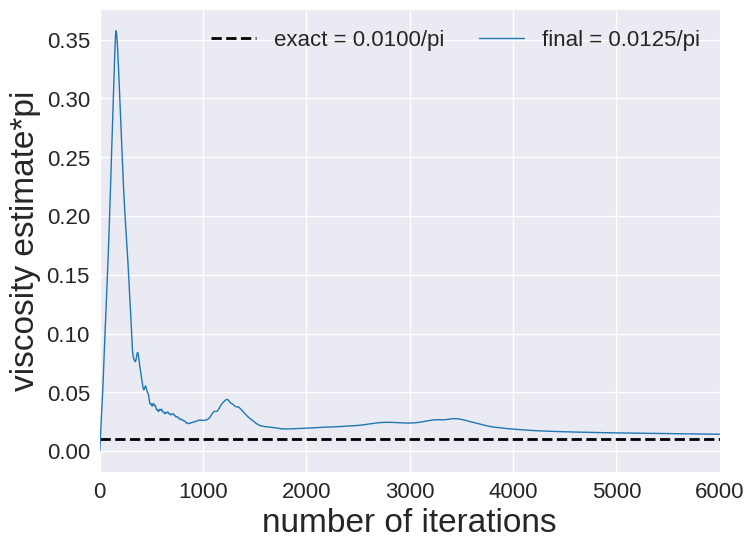

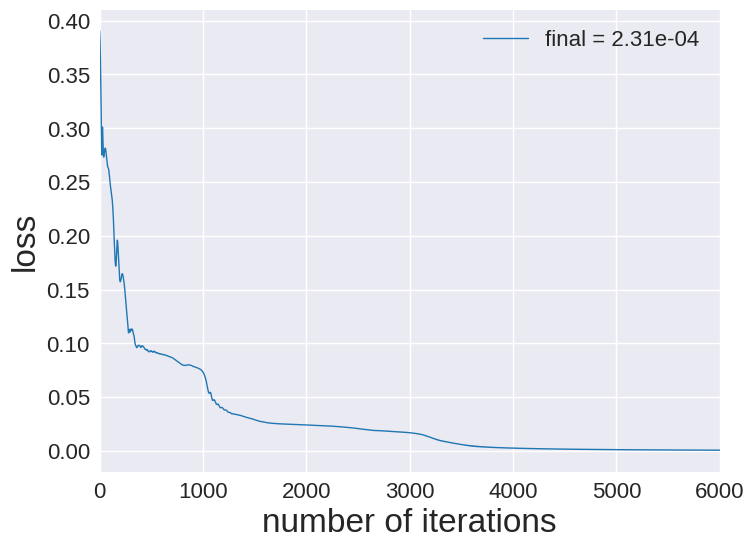

In [ ]:
#Display results

#vhat = np.load('Burgers_Inverse_vhat.npy')

from google.colab import files

colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7fdf','#bcbd22','#17becf']

# plot the evolution of vhat
plt.style.use('seaborn-v0_8')
fig=plt.figure(figsize=(8,6),dpi=100)
plt.xlabel('number of iterations',size=24)
plt.ylabel('viscosity estimate*pi',size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hlines(0.01,0,N,colors='black',linestyles='dashed',lw=2,label='exact = {:.4f}/pi'.format(np.pi*nu))
for r in range(M):
  plt.plot(np.arange(N),np.pi*vhat[r,],color=colors[r%10],lw=1,label='final = {:.4f}/pi'.format(np.pi*vhat[r,-1]))
plt.legend(fontsize=16,facecolor='white',ncol=2,columnspacing=1.6)
plt.xlim(0,6000)
fig.savefig('Fig-BurgersPINN_inverse_v.png',bbox_inches="tight",facecolor="white")
files.download('Fig-BurgersPINN_inverse_v.png')
print('viscosity estimate = ({:.4f} +/- {:.4f})/pi'.format(np.mean(np.pi*vhat[:,-1]),np.std(np.pi*vhat[:,-1])))

# plot the evolution of the loss
plt.style.use('seaborn-v0_8')
fig=plt.figure(figsize=(8,6),dpi=100)
plt.xlabel('number of iterations',size=24)
plt.ylabel('loss',size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
for r in range(M):
  plt.plot(np.arange(N),l[r,],color=colors[r%10],lw=1,label='final = {:.2e}'.format(l[r,-1]))
plt.legend(fontsize=16,facecolor='white',ncol=2,columnspacing=1.6)
plt.xlim(0,6000)
fig.savefig('Fig-BurgersPINN_inverse_e.png',bbox_inches="tight",facecolor="white")
files.download('Fig-BurgersPINN_inverse_e.png')